### Imports

In [1]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import networkx as nx

import folium
import branca.colormap as cmap # a folium spin-off for colormapping.

In [2]:
# Generate a random seed for reproducibility
seed = 42
import random
random.seed(seed)

### Simulation
The rules of the simulation are as follows:
- Each timestep t represents a day. We simulate for each Agent the course of one day
- Each agent represents a person living at a specific residence in Eindhoven
- Each agent has a list of amenity types that they visit regularly and a probability that they will visit it on any given day.
- Each agent can either walk or cycle to work. They randomly choose whether they walk or cycle each day.
- Some agents have a workplace. This can be one of the amenity types. They will always go to the same workplace with a high probability on each day.
- For the amenities they don’t work at, an agent keeps a list of the closest n amenities to their home or workplace, and go to one of those on the list based on a geometrically decreasing probability in order of proximity. We name this probability "curiosity".

In [3]:
# Initialization
# About everything required is cached to files
# If the files are not found, the code will download the data
# and save it to the files
# This takes a while
import person as ps

G = ps.dists.G_bike
# Get the nodes and edges of the graph
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# Adapted from eindhovenMap.py
tags = {
    'office': True,
    'amenity': [
        'pharmacy', 'hospital', 'clinic', 'doctors', 
        'school', 'kindergarten', 'college', 'university',  
        'cafe', 'restaurant', 'bar', 'cinema', 'theatre',  
        'community_centre', 'library', 'bicycle_rental',
        'place_of_worship', 
    ],
    'leisure': [
        'park', 'fitness_centre', 'sports_centre', 'stadium', 
        'dog_park', 'pitch', 'swimming_pool'
    ]
}

residences = ps.dists.residences
offices = ps.dists.offices
amenities = ps.dists.amenities
workplaces = ps.dists.workplaces
universities = ps.dists.universities

print(f"Number of residences: {len(residences)}")

print(f"Number of offices: {len(offices)}")

print(f"Number of amenities: {len(amenities)}")

print(f"Number of workplaces: {len(workplaces)}")


Loading networks v4
Loading networks from files...
Loading data from amenities.pickle...
Loading data from offices.pickle...
Loading data from universities.pickle...
Loading data from residences.pickle...
Loading data from pois.pickle...
Start node: 42724914, End node: 3888939248
Start node: 42724914, End node: 1270742846
Distance from residence to work: 6872.691709036078
Initializing distances for amenities...
[0.89839425 0.09537912]
Created BallTree for tags: ('cafe', 'park')
[972.7770611008673, 994.3110528377304, 1035.5237714338982, 1181.3340203948696, 1228.0297859789841, 1242.0191295703005, 1244.2036525881572, 1359.8096747020536, 1363.7917600174476, 1413.7335356406384]
[0.89839425 0.09537912]
[0.89839425 0.09537912]
Created BallTree for tags: ('restaurant', 'school')
[224.35505697376476, 578.7198440809634, 690.8813009756926, 919.1050327170394, 971.4566155091625, 1041.5644565182126, 1158.4702788564546, 1274.8458180871064, 1334.5017474809636, 1427.1585650234633]
[0.89839425 0.0953791

### Prep

We have a map of Eindhoven where we can sample two nodes: a randomly-chosen residence and randomly-chosen amenity. We can map the route between them with ox using matplotlib as backend. 

74156
703


c:\Users\euseb\AppData\Local\Programs\Python\Python313\Lib\site-packages\osmnx\plot.py:351: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(od_x, od_y, s=orig_dest_size, c=route_color, alpha=route_alpha, edgecolor="none")


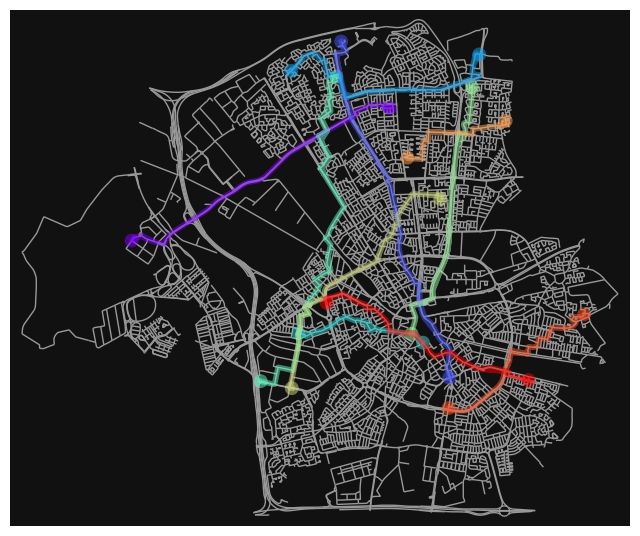

42605383
1271555674
                                                             geometry amenity  \
element id                                                                      
node    250852374                            POINT (5.52632 51.44886)  school   
        1699991564                           POINT (5.44156 51.43905)  school   
        2713602914                            POINT (5.45368 51.4309)  school   
        2717118986                           POINT (5.45731 51.42871)  school   
        2727533688                           POINT (5.44871 51.41487)  school   
...                                                               ...     ...   
way     1228473343  POLYGON ((5.45857 51.44283, 5.45874 51.44264, ...  school   
        1229167348  POLYGON ((5.50056 51.47491, 5.50176 51.47483, ...  school   
        1239211502  POLYGON ((5.44413 51.47413, 5.4447 51.47354, 5...  school   
        1375027985  POLYGON ((5.46187 51.45422, 5.46188 51.45421, ...  school   
        

In [4]:
# For now just simulate a single agent
# Create a random agent

print(len(residences))
print(len(amenities))

import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

routes = []
num_routes = 10
for i in range(num_routes):
    rcoords = residences.sample(1).geometry.values[0].centroid.coords[0]
    wcoords = offices.sample(1).geometry.values[0].centroid.coords[0]
    orig = ox.distance.nearest_nodes(G, X=rcoords[0], Y=rcoords[1]) 
    dest = ox.distance.nearest_nodes(G, X=wcoords[0], Y=wcoords[1]) 
    route = nx.shortest_path(G, orig, dest, weight='length')
    routes.append(route)

# Generate a list of colors from a colormap
colors = cm.rainbow(np.linspace(0, 1, num_routes))

# Plot all routes with different colors
fig, ax = ox.plot_graph_routes(
    G, 
    routes, 
    route_colors=colors, 
    route_linewidth=1, 
    node_size=0,
    show=False, 
    close=False
)
plt.show()

print(ox.distance.nearest_nodes(
    G, 
    X=rcoords[0],
    Y=rcoords[1],
))
print(ox.distance.nearest_nodes(
    G, 
    X=wcoords[0],
    Y=wcoords[1],
))

print(amenities[amenities['amenity'] == 'school'])




In [5]:
"""m = folium.Map(location=[residences.geometry.centroid.y.mean(), residences.geometry.centroid.x.mean()], zoom_start=13)

for i in range(100):
    rcoords = residences.sample(1).geometry.values[0].centroid.coords[0]
    wcoords = offices.sample(1).geometry.values[0].centroid.coords[0]
    orig = ox.distance.nearest_nodes(G, X=rcoords[0], Y=rcoords[1]) 
    dest = ox.distance.nearest_nodes(G, X=wcoords[0], Y=wcoords[1]) 
    route = nx.shortest_path(G, orig, dest, weight='length')
    route_nodes = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in route]
    folium.PolyLine(route_nodes, color="red", weight=2, opacity=0.7).add_to(m)

m
# Save the map to an HTML file
m.save("map.html")"""

'm = folium.Map(location=[residences.geometry.centroid.y.mean(), residences.geometry.centroid.x.mean()], zoom_start=13)\n\nfor i in range(100):\n    rcoords = residences.sample(1).geometry.values[0].centroid.coords[0]\n    wcoords = offices.sample(1).geometry.values[0].centroid.coords[0]\n    orig = ox.distance.nearest_nodes(G, X=rcoords[0], Y=rcoords[1]) \n    dest = ox.distance.nearest_nodes(G, X=wcoords[0], Y=wcoords[1]) \n    route = nx.shortest_path(G, orig, dest, weight=\'length\')\n    route_nodes = [(G.nodes[n][\'y\'], G.nodes[n][\'x\']) for n in route]\n    folium.PolyLine(route_nodes, color="red", weight=2, opacity=0.7).add_to(m)\n\nm\n# Save the map to an HTML file\nm.save("map.html")'

In [6]:
print(ps.dists.calculate_distances(
    ps.dists.G_walk, rcoords, wcoords
))

agent = ps.person(
    residence_coords= rcoords, 
    work_coords= wcoords,
    walk_speed=4,
    amenity_freqs={ ('cafe', 'park'): 0.5, ('school', 'restaurant'): 0.5 },
    seed=42
)
agent.simulate_day()


Start node: 42605383, End node: 5497596240
5589.938642118769
Start node: 42605383, End node: 5497596240
Start node: 42605383, End node: 1271555674
Distance from residence to work: 5589.938642118769
Initializing distances for amenities...
[0.89761824 0.09616115]
[807.4739419201583, 1211.8147343358733, 1261.3599617979178, 1590.400780294133, 1648.9264292237822, 1737.2797055447102, 2946.2707623149645, 3227.8581771325244, 3551.8651132300693, 3865.578250246374]
[0.89761824 0.09616115]
[0.89761824 0.09616115]
[366.3998876186884, 716.2413417384075, 745.2463838349294, 745.2463838349294, 907.9215763774605, 941.5927053351282, 991.1527728137977, 1024.4144429188602, 1101.1442456265643, 1864.030959062081]
[0.89761824 0.09616115]
Initializing work distances for amenities...
[5589.938642118771, 5589.938642118771, 5589.938642118772, 5589.938642118774, 5632.329482563503, 5646.3525005266, 5659.489412009509, 5671.554510412161, 5676.206368803991, 5714.408234214743]
[5589.938642118773, 5589.938642118773, 55

83.84907963178154

In [7]:

# Function to create random Person objects
def create_persons(children, students, adults, seniors, seed=42):
    persons = []
    for i in range(children):
        # Generate random residence coordinates
        print("Creating child: ", i)
        residence_coords = residences.sample(1).geometry.values[0].centroid.coords[0]

        walk_speed = random.uniform(3, 5)
        bike_speed = random.uniform(6, 12)
        bike_freq = random.uniform(0.0, 0.8)  # Frequency of biking

        amenity_freqs = {
            # According to statistics there are about 19k schoolchildren in eindhoven and 33k in ages 1-15
            # We can approximate the rest going to kindergarten (even if it's not 100% accurate)
            ('school',) if random.random() < 0.6 else ('kindergarten',): 1.0,
            ('park', 'playground'): random.uniform(0.2, 0.9),
            ('pharmacy', 'hospital', 'clinic', 'doctors'): random.uniform(0.05, 0.2),
            ('place_of_worship',): random.uniform(0.0, 0.5) #Sort by controversial
        }

        persons.append(
            ps.person(
                residence_coords=residence_coords,
                work_coords=None,
                walk_speed=walk_speed,
                bike_speed=bike_speed,
                bike_freq=bike_freq,
                work_freq=0.0,
                amenity_freqs=amenity_freqs,
                seed=seed
            )
        )

    for i in range(students):
        # Generate random residence coordinates
        print("Creating student: ", i)
        residence_coords = residences.sample(1).geometry.values[0].centroid.coords[0]
        work_coords = universities.sample(1).geometry.values[0].centroid.coords[0]

        walk_speed = random.uniform(3, 5)
        bike_speed = random.uniform(8, 20)
        bike_freq = random.uniform(0.0, 1.0)
        work_freq = random.uniform(0.4, 1.0)

        amenity_freqs = {
            ('cafe', 'restaurant', 'bar', 'cinema', 'theatre'): random.uniform(0.2, 0.9),
            ('community_centre', 'library', 'bicycle_rental'): random.uniform(0.0, 0.3),
            ('park', 'fitness_centre', 'sports_centre', 'dog_park', 'pitch', 'swimming_pool'): random.uniform(0.1, 0.9),
            ('pharmacy', 'hospital', 'clinic', 'doctors'): random.uniform(0.0, 0.5),
            ('place_of_worship',): random.uniform(0.0, 0.5) #Sort by controversial
        }

        curiosity = random.uniform(0.5, 1.0)

        persons.append(
            ps.person(
                residence_coords=residence_coords,
                work_coords=work_coords,
                walk_speed=walk_speed,
                bike_speed=bike_speed,
                bike_freq=bike_freq,
                work_freq=work_freq,
                amenity_freqs=amenity_freqs,
                curiosity=curiosity,
                seed=seed
            )
        )

    for i in range(adults):
        # Generate random residence coordinates
        print("Creating adult: ", i)
        residence_coords = residences.sample(1).geometry.values[0].centroid.coords[0]
        work_coords = offices.sample(1).geometry.values[0].centroid.coords[0]

        walk_speed = random.uniform(3, 5)
        bike_speed = random.uniform(8, 20)
        bike_freq = random.uniform(0.0, 1.0)
        work_freq = random.uniform(0.8, 1.0)

        amenity_freqs = {
            ('cafe', 'restaurant', 'bar', 'cinema', 'theatre'): random.uniform(0.1, 0.7),
            ('community_centre', 'library', 'bicycle_rental'): random.uniform(0.0, 0.3),
            ('park', 'fitness_centre', 'sports_centre', 'dog_park', 'pitch', 'swimming_pool'): random.uniform(0.1, 0.9),
            ('pharmacy', 'hospital', 'clinic', 'doctors'): random.uniform(0.05, 0.2),
            ('place_of_worship',): random.uniform(0.0, 0.5) #Sort by controversial
        }

        curiosity = random.uniform(0.5, 1.0)

        persons.append(
            ps.person(
                residence_coords=residence_coords,
                work_coords=work_coords,
                walk_speed=walk_speed,
                bike_speed=bike_speed,
                bike_freq=bike_freq,
                work_freq=work_freq,
                amenity_freqs=amenity_freqs,
                curiosity=curiosity,
                seed=seed
            )
        )
    for i in range(seniors):
        # Generate random residence coordinates
        print("Creating senior: ", i)
        residence_coords = residences.sample(1).geometry.values[0].centroid.coords[0]

        walk_speed = random.uniform(3, 5)
        bike_speed = random.uniform(8, 12)
        bike_freq = random.uniform(0.0, 1.0)
        work_freq = 0.0

        amenity_freqs = {
            ('cafe', 'restaurant', 'bar', 'cinema', 'theatre'): random.uniform(0.25, 0.75),
            ('community_centre', 'library', 'bicycle_rental'): random.uniform(0.0, 0.75),
            ('park', 'fitness_centre', 'sports_centre', 'dog_park', 'pitch', 'swimming_pool'): random.uniform(0.1, 0.5),
            ('pharmacy', 'hospital', 'clinic', 'doctors'): random.uniform(0.1, 0.5),
            ('place_of_worship',): random.uniform(0.0, 0.5) #Sort by controversial
        }

        curiosity = random.uniform(0.5, 1.0)

        persons.append(
            ps.person(
                residence_coords=residence_coords,
                work_coords=None,
                walk_speed=walk_speed,
                bike_speed=bike_speed,
                bike_freq=bike_freq,
                work_freq=work_freq,
                amenity_freqs=amenity_freqs,
                curiosity=curiosity,
                seed=seed
            )
        )
    return persons

    

def create_random_persons_nofreqs(num_persons):
    persons = []
    print("Residences: ", len(residences))
    print("Amenities: ", len(amenities))

    residences_samples = residences.sample(num_persons, replace=True)
    amenities_samples = amenities.sample(num_persons, replace=True)
    for i in range(num_persons):
        # Generate random residence coordinates
        residence_coords = residences_samples.geometry.values[i].centroid.coords[0]
        # Generate random work coordinates
        work_coords = amenities_samples.geometry.values[i].centroid.coords[0]
    
        
        # Generate random parameters
        walk_speed = random.uniform(3, 5)  # Walking speed in km/h
        bike_speed = random.uniform(8, 12)  # Biking speed in km/h
        bike_freq = random.uniform(0.0, 1.0)  # Frequency of biking
        work_freq = 1
        
        # Create a Person object
        person = ps.person(
            residence_coords=residence_coords,
            work_coords=work_coords,
            walk_speed=walk_speed,
            bike_speed=bike_speed,
            bike_freq=bike_freq,
            work_freq=work_freq,
            amenity_freqs=None,
            seed=seed
        )
        persons.append(person)
    return persons


In [14]:
import pickle
import os
import concurrent.futures
num_persons = 100
batches = 10
# Create some seniors who are not going to work
seniors_fp = "seniors.pickle"
if os.path.exists(seniors_fp):
    with open(seniors_fp, "rb") as f:
        seniors = pickle.load(f)
else:
    with concurrent.futures.ThreadPoolExecutor() as executor:
        seniors = list(executor.map(
            lambda i: create_persons(0, 0, 0, num_persons // batches),
            range(batches)
        ))
    seniors = [person for batch in seniors for person in batch]
    with open(seniors_fp, "wb") as f:
        pickle.dump(seniors, f)






Creating senior:  0
Creating senior:  0
Creating senior:  0
Creating senior:  0
Distance from residence to work: None
Initializing distances for amenities...
Distance from residence to work: None
Initializing distances for amenities...
Creating senior:  0
Distance from residence to work: None
Initializing distances for amenities...
Distance from residence to work: None
Initializing distances for amenities...
Creating senior:  0
Distance from residence to work: None
Initializing distances for amenities...
Creating senior:  0
Distance from residence to work: None
Initializing distances for amenities...
Creating senior:  0
Distance from residence to work: None
Initializing distances for amenities...
Creating senior:  0
Distance from residence to work: None
Initializing distances for amenities...
[0.89742432 0.0959058 ]
[0.89855044 0.09573015]
[0.89778972 0.0960505 ]
Distance from residence to work: None
Initializing distances for amenities...
[0.89859485 0.09512293]
Creating senior:  0
[0

Simulating a day...
Agent is walking today.
Visiting ('cafe', 'restaurant', 'bar', 'cinema', 'theatre') from residence: 159.20969168784913
Travel time to ('cafe', 'restaurant', 'bar', 'cinema', 'theatre') from residence: 2.3488401614420344 minutes
Total travel time for the day: 2.3488401614420344 minutes
Simulating day for person 1
Simulating a day...
Agent is biking today.
Visiting ('cafe', 'restaurant', 'bar', 'cinema', 'theatre') from residence: 175.02485233054142
Travel time to ('cafe', 'restaurant', 'bar', 'cinema', 'theatre') from residence: 1.2288876465690473 minutes
Total travel time for the day: 1.2288876465690473 minutes
Simulating day for person 1
Simulating a day...
Agent is biking today.
Visiting ('cafe', 'restaurant', 'bar', 'cinema', 'theatre') from residence: 170.41992421344565
Travel time to ('cafe', 'restaurant', 'bar', 'cinema', 'theatre') from residence: 1.1965554423072757 minutes
Total travel time for the day: 1.1965554423072757 minutes
Simulating day for person 1


c:\Users\euseb\AppData\Local\Programs\Python\Python313\Lib\site-packages\osmnx\plot.py:351: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(od_x, od_y, s=orig_dest_size, c=route_color, alpha=route_alpha, edgecolor="none")


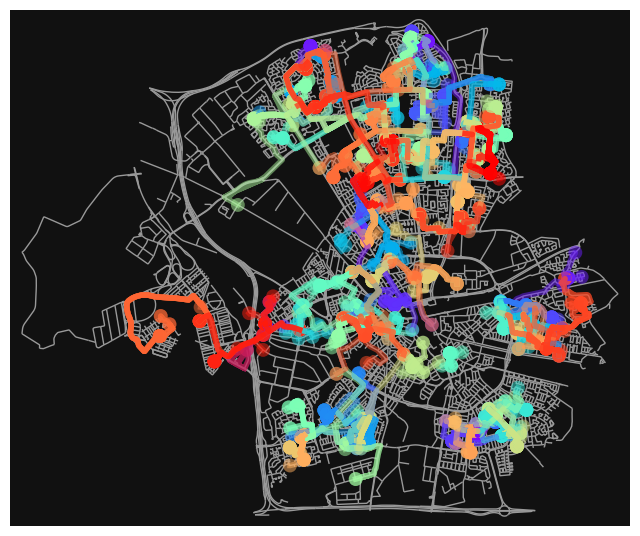

In [16]:
persons = seniors
for i in range(num_persons):
    for j in range(4):
        persons[i].simulate_day()
        print(f"Simulating day for person {i+1}")        

routes = []

for person in persons:
    residence_coords = person.residence_coords
    amenity_coords_list = person.df_travel["amenity_coords"].copy()
    for amenity_coords in amenity_coords_list:
        # Plot the route
        orig = ox.distance.nearest_nodes(G, X=residence_coords[0], Y=residence_coords[1])
        dest = ox.distance.nearest_nodes(G, X=amenity_coords[0], Y=amenity_coords[1])
        route = nx.shortest_path(G, orig, dest, weight='length')
        routes.append(route)
        
# Generate a list of colors from a colormap
colors = cm.rainbow(np.linspace(0, 1, len(routes)))

# Plot all routes with different colors
fig, ax = ox.plot_graph_routes(
    G, 
    routes, 
    route_colors=colors, 
    route_linewidth=1, 
    node_size=0,
    show=False, 
    close=False
)
plt.show()

    



In [19]:
import pandas as pd
from folium.plugins import HeatMap

for i in range(num_persons):
    for j in range(100):
        persons[i].simulate_day()
        print(f"Simulating day for person {i+1}")        

# Aggregate all travel dataframes into one
all_travel = pd.concat([person.df_travel for person in persons], ignore_index=True)

# Group by amenity_coords and count visits
# amenity_coords is a tuple (lon, lat), so we split it into two columns
all_travel[['lon', 'lat']] = pd.DataFrame(all_travel['amenity_coords'].tolist(), index=all_travel.index)
visit_counts = all_travel.groupby(['lat', 'lon']).size().reset_index(name='count')

# Prepare data for HeatMap: [[lat, lon, count], ...]
heat_data = visit_counts[['lat', 'lon', 'count']].values.tolist()

# Create the Folium map
m = folium.Map(location=[visit_counts['lat'].mean(), visit_counts['lon'].mean()], zoom_start=13)
HeatMap(heat_data, radius=10, blur=15, max_zoom=1).add_to(m)
m.save("visit_heatmap.html")
m

Simulating a day...
Agent is walking today.
Visiting ('cafe', 'restaurant', 'bar', 'cinema', 'theatre') from residence: 159.20969168784913
Travel time to ('cafe', 'restaurant', 'bar', 'cinema', 'theatre') from residence: 2.3488401614420344 minutes
Visiting ('community_centre', 'library', 'bicycle_rental') from residence: 361.9891572826517
Travel time to ('community_centre', 'library', 'bicycle_rental') from residence: 5.340470555643574 minutes
Total travel time for the day: 7.689310717085608 minutes
Simulating day for person 1
Simulating a day...
Agent is biking today.
Visiting ('park', 'fitness_centre', 'sports_centre', 'dog_park', 'pitch', 'swimming_pool') from residence: 77.70533238297575
Travel time to ('park', 'fitness_centre', 'sports_centre', 'dog_park', 'pitch', 'swimming_pool') from residence: 0.5455860797279339 minutes
Visiting ('place_of_worship',) from residence: 230.97965987498986
Travel time to ('place_of_worship',) from residence: 1.6217585494260947 minutes
Total travel 

In [20]:
import folium

# Use the visit_counts DataFrame from your previous aggregation
# visit_counts has columns: ['lat', 'lon', 'count']

# Create a Folium map centered on the mean location
m = folium.Map(location=[visit_counts['lat'].mean(), visit_counts['lon'].mean()], zoom_start=13)

# Optionally, scale the radius by visit count (e.g., min 3, max 15)
min_radius = 3
max_radius = 15
min_count = visit_counts['count'].min()
max_count = visit_counts['count'].max()

for _, row in visit_counts.iterrows():
    # Scale radius by count
    radius = min_radius + (max_radius - min_radius) * (row['count'] - min_count) / (max_count - min_count) if max_count > min_count else min_radius
    folium.CircleMarker(
        location=(row['lat'], row['lon']),
        radius=radius,
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup=f"Visits: {row['count']}"
    ).add_to(m)

m.save("visit_dots_map.html")

In [ ]:
# amenity_type is a tuple, convert to string for grouping
all_travel['amenity_type_str'] = all_travel['amenity_type'].apply(lambda x: ','.join(x) if isinstance(x, tuple) else str(x))
mean_travel_time = all_travel.groupby('amenity_type_str')['travel_time'].mean().reset_index()
mean_travel_time = mean_travel_time.sort_values('travel_time')
print(mean_travel_time)



                                    amenity_type_str  travel_time
2  park,fitness_centre,sports_centre,dog_park,pit...     4.286879
0                 cafe,restaurant,bar,cinema,theatre     7.356793
3                   pharmacy,hospital,clinic,doctors    10.266355
1            community_centre,library,bicycle_rental    12.232627
4                                   place_of_worship    15.052954


In [22]:
visit_counts = all_travel['amenity_type_str'].value_counts().reset_index()
visit_counts.columns = ['amenity_type', 'visit_count']
print(visit_counts)

                                        amenity_type  visit_count
0            community_centre,library,bicycle_rental         6394
1                   pharmacy,hospital,clinic,doctors         5232
2  park,fitness_centre,sports_centre,dog_park,pit...         4385
3                 cafe,restaurant,bar,cinema,theatre         4216
4                                   place_of_worship          526


In [23]:
mean_time_by_mode = all_travel.groupby('mode')['travel_time'].mean().reset_index()
print(mean_time_by_mode)

   mode  travel_time
0  bike     5.354521
1  walk    10.687130


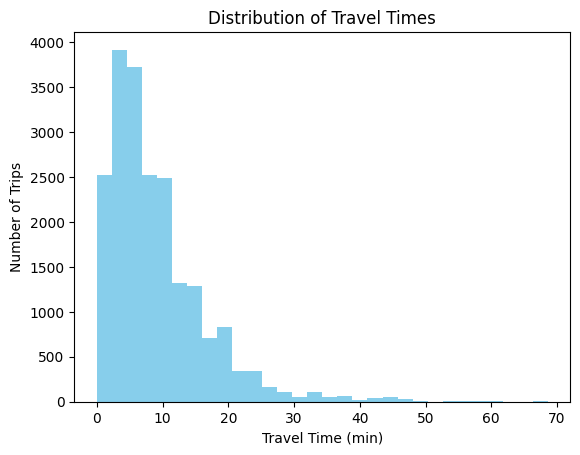

In [24]:
import matplotlib.pyplot as plt
plt.hist(all_travel['travel_time'], bins=30, color='skyblue')
plt.xlabel('Travel Time (min)')
plt.ylabel('Number of Trips')
plt.title('Distribution of Travel Times')
plt.show()

In [25]:
most_visited = all_travel.groupby(['lat', 'lon']).size().reset_index(name='visit_count')
most_visited = most_visited.sort_values('visit_count', ascending=False)
print(most_visited.head(10))

           lat       lon  visit_count
517  51.487855  5.443362          351
525  51.488692  5.473758          339
190  51.440801  5.461558          326
441  51.476985  5.494351          307
415  51.471145  5.468560          271
199  51.441313  5.453903          262
434  51.476130  5.490281          259
439  51.476973  5.494520          255
470  51.479938  5.465043          250
294  51.450013  5.456777          240


In [ ]:
# Data based on Allecijfers.nl
# Eindhoven has about 233k inhabitants
children_nr = 16
students_nr = 17
adults_nr = 69
seniors_nr = 20

batches = 16

# Create random persons

# Check if the file exists
people_fp = "people.pkl"
if os.path.exists(people_fp):
    with open(people_fp, "rb") as f:
        persons = pickle.load(f)

else:
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Create a list of futures
        futures = []
        for i in range(batches):
            future = executor.submit(
                create_persons, 
                children_nr, 
                students_nr, 
                adults_nr, 
                seniors_nr,
                seed=seed
            )
            futures.append(future)

        # Wait for all futures to complete and collect results
        persons = []
        for future in concurrent.futures.as_completed(futures):
            persons.extend(future.result())

    # Save the list of Person objects to a file
    with open(people_fp, "wb") as f:
        pickle.dump(persons, f)


Residences:  3706
Amenities:  703
Start node: 1269564265, End node: 6426227731
Start node: 1269564265, End node: 6426227731
Distances from residence to work:
3076.339273215413
3076.339273215413
Start node: 42578887, End node: 61101653
Start node: 42578887, End node: 61101653
Distances from residence to work:
2981.0703437097936
2981.0703437097936
Start node: 42607514, End node: 1250611310
Start node: 42607514, End node: 1250611310
Distances from residence to work:
6431.347501515435
6431.347501515435
Start node: 42624452, End node: 42614082
Start node: 42624452, End node: 42614082
Distances from residence to work:
3961.8628394558973
3961.8628394558973
Start node: 12444405445, End node: 42568891
Start node: 12444405445, End node: 42568891
Distances from residence to work:
5025.159275044796
5025.159275044796
Start node: 42671516, End node: 42598357
Start node: 42671516, End node: 42598357
Distances from residence to work:
5085.541005206407
5085.541005206407
Start node: 42614972, End node: 

In [ ]:
# Create a DataFrame to store travel times
travel_times = pd.DataFrame(columns=['lat', 'lon', 'travel_time'])

# Create a DataFrame to store visited locations
visited_locations = pd.DataFrame(columns=['lat', 'lon', 'travel_time'])

# Also for visited amenity types
visited_amenities = pd.DataFrame(columns=['type', 'count', 'mean_travel_time'])



Agent is walking today.
Travel time to work: 40.024897061252496 minutes
No amenity frequencies specified.
Agent is walking today.
Travel time to work: 41.801902442166856 minutes
No amenity frequencies specified.
Agent is walking today.
Travel time to work: 90.18323281008544 minutes
No amenity frequencies specified.
Agent is walking today.
Travel time to work: 55.55501373982471 minutes
No amenity frequencies specified.
Agent is walking today.
Travel time to work: 70.46503220395724 minutes
No amenity frequencies specified.
Agent is biking today.
Travel time to work: 37.67047403642463 minutes
No amenity frequencies specified.
Agent is biking today.
Travel time to work: 31.31385806892655 minutes
No amenity frequencies specified.
Agent is walking today.
Travel time to work: 39.67267271986118 minutes
No amenity frequencies specified.
Agent is biking today.
Travel time to work: 39.69228571748113 minutes
No amenity frequencies specified.
Agent is walking today.
Travel time to work: 73.74238095

In [ ]:
print(df.describe())
# Create a Folium map centered around the average coordinates
m = folium.Map(location=[df['lat'].mean(), df['lon'].mean()], zoom_start=13)
# Create a colormap
colormap = cmap.LinearColormap(
    colors=['blue', 'green', 'yellow', 'red'], 
    vmin=df['travel_time'].min(), 
    vmax=df['travel_time'].max()
)
# Add points to the map
for _, row in df.iterrows():
    folium.CircleMarker(
        location=(row['lat'], row['lon']),
        radius=5,
        color=colormap(row['travel_time']),
        fill=True,
        fill_opacity=0.6,
        popup=f"Travel Time: {row['travel_time']:.2f} min"
    ).add_to(m)

# Add the colormap to the map
colormap.add_to(m)
# Save the map to an HTML file
m.save("travel_time_map.html")
# Display the map in a Jupyter notebook
m

              lat         lon  travel_time
count  100.000000  100.000000   100.000000
mean    51.445120    5.474948    42.005970
std      0.017784    0.020730    28.185124
min     51.415309    5.410552     3.442043
25%     51.433944    5.463716    18.987602
50%     51.440140    5.473752    36.455296
75%     51.452634    5.487181    66.137490
max     51.493967    5.525845   131.462813


In [ ]:
from folium.plugins import HeatMap

# Normalize the travel_time into a weight between 0 and 1 if needed
df["weight"] = df["travel_time"] / df["travel_time"].max()

heat_data = [[row["lat"], row["lon"], row["weight"]] for _, row in df.iterrows()]

# Step 4: Create the Folium map
m = folium.Map(location=[df["lat"].mean(), df["lon"].mean()], zoom_start=13)
HeatMap(heat_data, radius=10, blur=15, max_zoom=1).add_to(m)
m
